Skintone Recognition Model 

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report

from keras.optimizers import Adam
from keras.models import Sequential
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.mobilenet_v2 import preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense, Dropout

Loading Images to Array

In [2]:
def load_images_to_array(folder_path):
    image_list = []
    
    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            try:
                
                image_path = os.path.join(folder_path, filename)
                with Image.open(image_path) as img:
                    # image to  NumPy array
                    img_array = np.array(img)
                    
                    image_list.append(img_array)
                    print(f"Loaded: {filename}")
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    
    return image_list

if __name__ == "__main__":
    # folder_path = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\mst_faces_resized'
    folder_path = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\mst_faces_resized'
    images_as_arrays = load_images_to_array(folder_path)
    

Loaded: 10_PXL_20220922_175138290.jpg
Loaded: 10_PXL_20220922_175140560.jpg
Loaded: 10_PXL_20220922_175142212.jpg
Loaded: 10_PXL_20220922_175145715.jpg
Loaded: 10_PXL_20220922_175149121.jpg
Loaded: 10_PXL_20220922_175151358.jpg
Loaded: 10_PXL_20220922_175152817.jpg
Loaded: 10_PXL_20220922_175154352.jpg
Loaded: 10_PXL_20220922_175155744.jpg
Loaded: 10_PXL_20220922_175157945.jpg
Loaded: 10_PXL_20220922_175159465.jpg
Loaded: 10_PXL_20220922_175201134.jpg
Loaded: 10_PXL_20220922_175203683.jpg
Loaded: 10_PXL_20220922_175205602.jpg
Loaded: 10_PXL_20220922_175210525.jpg
Loaded: 10_PXL_20220922_175212910.jpg
Loaded: 10_PXL_20220922_175213980.jpg
Loaded: 10_PXL_20220922_175216751.jpg
Loaded: 10_PXL_20220922_175218550.jpg
Loaded: 10_PXL_20220922_175222824.jpg
Loaded: 10_PXL_20220922_175223698.jpg
Loaded: 10_PXL_20220922_175304753.jpg
Loaded: 10_PXL_20220922_175307113.jpg
Loaded: 10_PXL_20220922_175309582.jpg
Loaded: 10_PXL_20220922_175312693.jpg
Loaded: 10_PXL_20220922_175315326.jpg
Loaded: 10_P

Making Array of Labels

In [3]:
# folder_path = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\mst_faces_resized'
folder_path = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\mst_faces_resized'

labels = []

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):

        # Extracting the label 
        label = filename.split('_')[0]
        labels.append(label)

labels = np.array(labels, dtype=np.int32)

# range 0-9
labels = labels - 1

print(f"Length of labels array: {len(labels)}")
print("Extracted Labels:", labels)

Length of labels array: 1055
Extracted Labels: [9 9 9 ... 8 8 8]


Normalizing Picture Array

In [4]:
# (0->255 converted to -1->1)

images_as_arrays_normalized = [preprocess_input(image) for image in images_as_arrays]

#Length of array (number of images)
print(f"length of image array: {len(images_as_arrays_normalized)}")

length of image array: 1055


In [5]:
# Assigning Variables 

# dataset_path = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\mst_faces_resized'
dataset_path = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\mst_faces_resized'
input_shape = (224, 224, 3)
classes = ['MST 1', 'MST 2', 'MST 3', 'MST 4', 'MST 5', 'MST 6', 'MST 7', 'MST 8', 'MST 9', 'MST 10']

epochs = 120  
batch_size = 32

Data splitting (Train and Test)

In [6]:
# (80% train, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(images_as_arrays_normalized, labels, test_size=0.2, random_state=69)

# (50% temp, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to NumPy arrays 
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(f"X train Shape: {X_train.shape}")
print(f"y train Shape: {y_train.shape}\n")
print(f"X val Shape: {X_val.shape}")
print(f"y val Shape: {y_val.shape}\n")
print(f"X test Shape: {X_test.shape}")
print(f"y test Shape: {y_test.shape}")


X train Shape: (844, 224, 224, 3)
y train Shape: (844,)

X val Shape: (105, 224, 224, 3)
y val Shape: (105,)

X test Shape: (106, 224, 224, 3)
y test Shape: (106,)


In [7]:
base_model = MobileNetV2(input_shape=input_shape, 
                         include_top=False, 
                         weights='imagenet') #top layer exlcuded
base_model.trainable = False #Freezes the Layers (Weights won't get updated)

In [8]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer=Adam(lr=1e-4), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Adding Callbacks 

In [9]:
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6) #Reduces learning rate when no improvment in validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  #Stops when we see no improvement

In [10]:
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs= epochs, 
                    batch_size= batch_size,
                    callbacks=[lr_scheduler, early_stopping]
                    )

test_loss, test_accuracy = model.evaluate(X_test, y_test)

Epoch 1/120
27/27 [==============================] - 16s 497ms/step - loss: 1.9002 - accuracy: 0.3555 - val_loss: 1.2400 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 2/120
27/27 [==============================] - 12s 443ms/step - loss: 0.9335 - accuracy: 0.7038 - val_loss: 0.7929 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 3/120
27/27 [==============================] - 12s 448ms/step - loss: 0.6186 - accuracy: 0.8152 - val_loss: 0.6927 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 4/120
27/27 [==============================] - 12s 447ms/step - loss: 0.4411 - accuracy: 0.8637 - val_loss: 0.5499 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 5/120
27/27 [==============================] - 13s 472ms/step - loss: 0.3201 - accuracy: 0.9135 - val_loss: 0.4723 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 6/120
27/27 [==============================] - 12s 459ms/step - loss: 0.2142 - accuracy: 0.9455 - val_loss: 0.4728 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 7/120
27/27 [==============================] - 12s 4

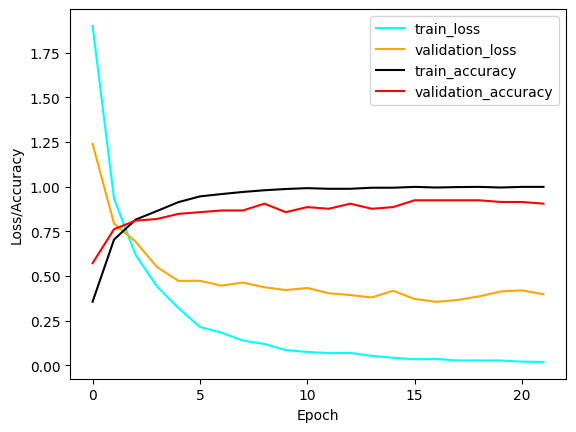

Test Accuracy: 0.9150943160057068
Test Loss: 0.23863911628723145


In [12]:
plt.plot(history.history['loss'], label='train_loss', color = 'Cyan')
plt.plot(history.history['val_loss'], label='validation_loss', color = 'Orange')
plt.plot(history.history['accuracy'], label='train_accuracy', color = 'black')
plt.plot(history.history['val_accuracy'], label='validation_accuracy', color = 'red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

# model_save_path = 'E:\\University\\FYP Stuff\\Models For SkinTone Recognition\\Skintone_Recognition_3.h5'
model_save_path = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\skintone_recog1.h5'
model.save(model_save_path)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

In [13]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

4/4 [==============================] - 2s 311ms/step
Classification Report:
              precision    recall  f1-score   support

       MST 1       1.00      0.88      0.93        16
       MST 2       0.94      1.00      0.97        16
       MST 3       1.00      0.80      0.89         5
       MST 4       0.95      0.95      0.95        21
       MST 5       1.00      1.00      1.00         6
       MST 6       0.86      0.92      0.89        13
       MST 7       1.00      1.00      1.00         6
       MST 8       1.00      0.62      0.77         8
       MST 9       0.67      0.80      0.73         5
      MST 10       0.77      1.00      0.87        10

    accuracy                           0.92       106
   macro avg       0.92      0.90      0.90       106
weighted avg       0.93      0.92      0.91       106



In [14]:
print('success')

success
